Note:  For now the code cells must be opened for the dropdown lists to work correctly.

In [34]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Clean Water Act Historic Compliance Violations

This notebook examines ECHO data using NPDES_QNCR_HISTORY, 
which reports the number of non-compliance violations in
four categories:
1) Effluent (E90) violations
2) Compliance schedule violagions,
3) Single event violations
4) Permit schedule violations

A state and congressional district must be chosen.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

column_mapping = {
    "REGISTRY_ID": str,
    "FAC_NAME": str,
    "FAC_ZIP": str,
    "FAC_LAT": float,
    "FAC_LONG": float,
    "FAC_STATE": str,
    "FAC_DERIVED_CD113": str,
    "FAC_DERIVED_CB2010": str,
    "NPDES_IDS": str,
}

In [18]:
#data_location = "https://github.com/edgi-govdata-archiving/echo-data/blob/master/ECHO_EXPORTER.csv?raw=true" # Where the ECHO data is saved
#sql="SELECT * FROM ECHO_EXPORTER where FAC_ZIP=%s" %(my_zip)
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where e.REGISTRY_ID='110020148008' and e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and f.ZIP_CODE=%s" %(my_zip)
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where  e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and STR_TO_DATE(EARLIEST_FRV_DETERM_DATE, '%%m-%%d-%%Y') >= DATE_SUB(NOW(),INTERVAL 1 YEAR) and f.ZIP_CODE=%s" %(my_zip)
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where  e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and f.ZIP_CODE=%s" %(my_zip)
#sql='show tables'  
#sql= 'show columns from `ICIS-AIR_VIOLATION_HISTORY` '

sql = "select FAC_STATE, NPDES_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where NPDES_FLAG = 'Y'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
# print(data_location)


select FAC_STATE, NPDES_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where NPDES_FLAG = 'Y'


In [19]:
# exporter_data = "data/echo_exporter_npdes.csv" # Where the ECHO data resides
# exporter_data = "https://stevenehansen.com/EDGI/echo_exporter_npdes.csv" # Where the ECHO data resides
# echo_data = pd.read_csv(exporter_data, usecols = list(column_mapping.keys()), dtype=column_mapping)

echo_data = pd.read_csv(data_location,header = 0)


In [20]:
states = ["all", "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='all',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', options=('all', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA…

In [21]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s NDIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 10007 NDIS facilities in WA tracked in the ECHO database.


In [22]:
my_state_facs

,FAC_STATE,NPDES_IDS,FAC_DERIVED_CD113
30,WA,WA0030074,7.0
84,WA,WAR307188,6.0
139,WA,WA0029351 WAL029351 WAU000005,8.0
367,WA,WAR002521,3.0
384,WA,WAR305691,2.0
...,...,...,...
600480,WA,WAR127195,5.0
600596,WA,WAR304506,4.0
600628,WA,WAR306236,10.0
600670,WA,WAP007438,1.0


In [25]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=0,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0)

In [27]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s NDIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 1549 NDIS facilities in WA district 1 tracked in the ECHO database.


Next look up the compliance history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [31]:
# npdes_qncr_data = "data/npdes/NPDES_QNCR_HISTORY.csv" 
# npdes_qncr_data = "https://stevenehansen.com/EDGI/NPDES_QNCR_HISTORY.csv" 
sql = "select NPDES_ID, YEARQTR, NUME90Q, NUMCVDT, NUMSVCD, NUMPSCH from NPDES_QNCR_HISTORY"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)

qncr_data = pd.read_csv(data_location,header = 0)
qncr_data.set_index( "NPDES_ID", inplace=True)
# print( qncr_data )

select NPDES_ID, YEARQTR, NUME90Q, NUMCVDT, NUMSVCD, NUMPSCH from NPDES_QNCR_HISTORY


In [33]:
qncr_data = qncr_data[ (qncr_data['YEARQTR'] > 20100) & (qncr_data['YEARQTR'] < 20200) ]

In [38]:
# The NDIS_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in NPDES_QNCR_HISTORY.

my_cd_npdes = pd.DataFrame()
no_data_ids = []
for ids in my_cd_facs['NPDES_IDS']:
    for npdes_id in ids.split():
        try:
            npdes_data = qncr_data.loc[ npdes_id ]
            frames = [my_cd_npdes, npdes_data]
            my_cd_npdes = pd.concat( frames )
        except KeyError:
            no_data_ids.append( npdes_id )


In [39]:
my_cd_groups = my_cd_npdes.groupby( 'YEARQTR' )[['NUMCVDT','NUME90Q','NUMPSCH','NUMSVCD']].sum()

NUMCVDT - (Number of Compliance Schedule Violations in Quarter) A count of the number of compliance schedule violations reported in the quarter, defined by YEARQTR.

NUME90Q - (Number of E90 Violations in Quarter) A count of the number of effluent violations (E90) reported in the quarter, defined by YEARQTR.

NUMPSCH - (Number of Permit Schedule Violations in Quarter) A count of the number of permit schedule violations reported in the quarter, defined by YEARQTR.

NUMSVCD - (Number of Single Event Violations in Quarter) A count of the number of single event violations reported in the quarter, defined by PRHQRTR.

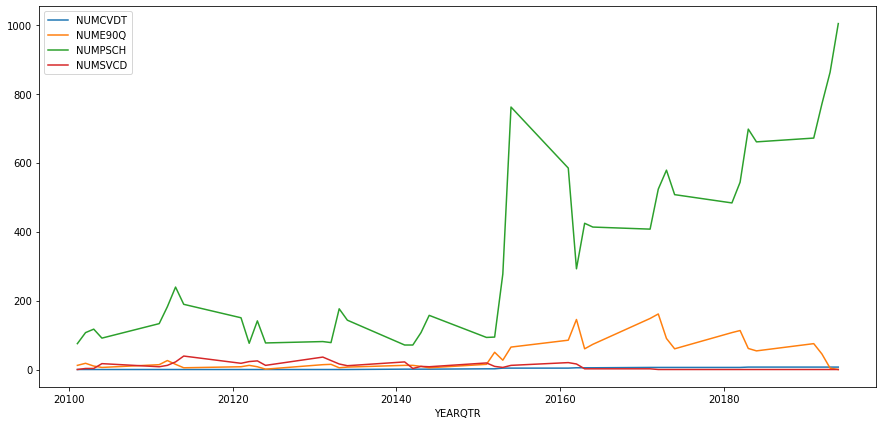

In [40]:
fig, ax = plt.subplots(figsize=(15,7))
my_cd_groups.plot(ax=ax)

How is the number of effluent violations (NUME90Q) related to the number of permit schedule violations (NUMPSCH)?